In [1]:
import os
import uuid
import asyncio
from typing import TypedDict, List
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

load_dotenv(override=True)
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

llm = ChatOpenAI(model="gpt-5-nano",temperature=0,api_key=OPENAI_API_KEY,streaming=False)

streaming_llm = ChatOpenAI(model="gpt-5-nano",temperature=0,api_key=OPENAI_API_KEY,streaming=True)

In [2]:
class DistributedState(TypedDict):
    trace_id: str
    user_task: str
    subtasks: List[str]
    worker_results: List[str]
    final_answer: str

In [3]:
async def task_splitter(state: DistributedState):

    prompt = f"""
    Break the following task into 3 independent subtasks
    that can be executed in parallel:

    {state["user_task"]}

    Return as numbered list.
    """

    response = await llm.ainvoke([HumanMessage(content=prompt)])

    subtasks = [
        line.strip()
        for line in response.content.split("\n")
        if line.strip()
    ]

    return {
        "subtasks": subtasks,
        "worker_results": []
    }

In [4]:
async def worker_execute(subtask: str):

    prompt = f"""
    Execute this distributed subtask clearly:

    {subtask}
    """

    response = await llm.ainvoke([HumanMessage(content=prompt)])

    return response.content

In [5]:
async def worker_pool(state: DistributedState):

    subtasks = state["subtasks"]

    print("\n--- Distributing Tasks Across Worker Pool ---\n")

    tasks = [
        worker_execute(subtask)
        for subtask in subtasks
    ]

    results = await asyncio.gather(*tasks)

    return {
        "worker_results": results
    }

In [6]:
async def aggregator(state: DistributedState):

    combined = "\n\n".join(state["worker_results"])

    prompt = f"""
    Combine the following distributed worker results
    into a coherent final response:

    {combined}
    """

    print("\n--- Aggregating Worker Results ---\n")

    final_text = ""

    async for chunk in streaming_llm.astream(
        [HumanMessage(content=prompt)]
    ):
        if chunk.content:
            print(chunk.content, end="", flush=True)
            final_text += chunk.content

    return {
        "final_answer": final_text
    }

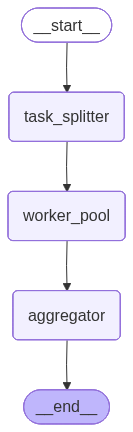

In [7]:
workflow = StateGraph(DistributedState)

workflow.add_node("task_splitter", task_splitter)
workflow.add_node("worker_pool", worker_pool)
workflow.add_node("aggregator", aggregator)

workflow.set_entry_point("task_splitter")

workflow.add_edge("task_splitter", "worker_pool")
workflow.add_edge("worker_pool", "aggregator")
workflow.add_edge("aggregator", END)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
async def run():

    initial_state = {
        "trace_id": str(uuid.uuid4()),
        "user_task": "Design a AI system for fraud detection in stock market",
        "subtasks": [],
        "worker_results": [],
        "final_answer": ""
    }

    await graph.ainvoke(initial_state)

await run()


--- Distributing Tasks Across Worker Pool ---


--- Aggregating Worker Results ---

Here’s a unified, coherent plan that combines the distributed work you provided into a single, actionable blueprint. It weaves together Data & Labeling Infrastructure, data sources ingestion, labeling strategy (fraud signals), modeling/evaluation engine, feature store/lineage, monitoring, deployment, and governance into one end-to-end platform. The plan is organized for phased implementation, scalable execution, and clear ownership.

Executive summary
- Objective: Build a scalable, auditable data platform for ingesting diverse data sources, labeling ground-truth (including fraud signals), training and evaluating models in parallel, serving features and models with provenance, and enforcing governance, security, and compliance.
- Scope: Data ingestion (trades, quotes, order books, settlements, news, corporate actions, reference data), labeling workflows with QA and IAA, feature engineering (temporal, ma